In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

<h1>Data Read </h1>

In [69]:
dt = pd.read_excel('Real estate valuation data set.xlsx')
data = dt.loc[:,"X1 transaction date":"Y house price of unit area"]
data.head()

FE_dt = pd.read_excel('Real estate valuation data set after FE.xlsx')
FE_data = FE_dt.loc[:,"X2 house age":"coord_pca2"]

In [70]:
FE_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
X2 house age                              414 non-null float64
X3 distance to the nearest MRT station    414 non-null float64
X4 number of convenience stores           414 non-null int64
X5 latitude                               414 non-null float64
X6 longitude                              414 non-null float64
Y house price of unit area                414 non-null float64
temperature                               414 non-null float64
coord_pca1                                414 non-null float64
coord_pca2                                414 non-null float64
dtypes: float64(8), int64(1)
memory usage: 29.2 KB


In [71]:
'''---------------------------split data-----------------------------'''
train_x = data.sample(frac=0.8,random_state=0)
test_x = data.drop(train_x.index)

train_xfe = FE_data.sample(frac=0.8,random_state=0)
test_xfe = FE_data.drop(train_xfe.index)

train_y = train_x.pop('Y house price of unit area')
test_y = test_x.pop('Y house price of unit area')

train_yfe = train_xfe.pop('Y house price of unit area')
test_yfe = test_xfe.pop('Y house price of unit area')

#Alpha의 의미??
#alpha값을 높이면 계수를 0에 가깝게만들어서 훈련세트의 성능은 나빠지지만,
#일반화에는 도움을 줌.
al = 1

<h1>Correlation</h1>

In [6]:
corr_data = data.corr()
corr_data["Y house price of unit area"].sort_values(ascending=False)

Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087529
X2 house age                             -0.210567
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64

<h5>Feature Engineering</h5>
Using Logarithm and SQRT

In [10]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the mpg column
    if col == 'Y house price of unit area':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = numeric_subset

# Drop cars without an mpg
features = features.dropna(subset = ['Y house price of unit area'])

# Find correlations with the building 
correlations = features.corr()['Y house price of unit area'].dropna().sort_values()



In [11]:
correlations.head(10)

log_X3 distance to the nearest MRT station    -0.734339
sqrt_X3 distance to the nearest MRT station   -0.729893
X3 distance to the nearest MRT station        -0.673613
sqrt_X2 house age                             -0.291438
log_X2 house age                              -0.244942
X2 house age                                  -0.210567
X1 transaction date                            0.087529
sqrt_X1 transaction date                       0.087529
log_X1 transaction date                        0.087530
log_X4 number of convenience stores            0.481823
Name: Y house price of unit area, dtype: float64

In [12]:
correlations.tail(10)

log_X4 number of convenience stores     0.481823
X6 longitude                            0.523287
sqrt_X6 longitude                       0.523295
log_X6 longitude                        0.523304
X5 latitude                             0.546307
sqrt_X5 latitude                        0.546341
log_X5 latitude                         0.546375
sqrt_X4 number of convenience stores    0.555806
X4 number of convenience stores         0.571005
Y house price of unit area              1.000000
Name: Y house price of unit area, dtype: float64

<h3>Plots</h3>

In [19]:
def rmse (yt, yp):
    return np.sqrt(np.mean((yt-yp)**2))
def mse (yt, yp):
    return np.mean((yt-yp)**2)

def train(model, x, y) :
    model.fit(x,y)

def test(model, xtest,ytest) :
    predictions = model.predict(xtest)
    model_rmse = rmse(ytest, predictions)
    return model_rmse

In [20]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
train(reg, train_x, train_y)

li_err1 = test(reg, train_x, train_y)
print("Linear regression")
print("train rmse: ", li_err1)

li_err2 = test(reg, test_x, test_y)
print("test rmse: ", li_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("----------------------------------------------------")

reg = LinearRegression()
train(reg, train_xfe, train_yfe)

li_err1fe = test(reg, train_xfe, train_yfe)
print("After Feature Engineering")
print("train rmse: ", li_err1fe)

li_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", li_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

Linear regression
train rmse:  8.914367920471367
test rmse:  8.2788288681249
훈련 세트의 정확도 : 0.58
테스트 세트의 정확도 : 0.57
----------------------------------------------------
After Feature Engineering
train rmse:  8.00396791186868
test rmse:  7.720009795061545
훈련 세트의 정확도 : 0.66
테스트 세트의 정확도 : 0.63


In [60]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=al)
train(reg, train_x, train_y)

rd_err1 = test(reg, train_x, train_y)
print("Ridge regression")
print("train rmse: ", rd_err1)

rd_err2 = test(reg, test_x, test_y)
print("test rmse: ", rd_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("----------------------------------------------------")

reg = LinearRegression()
train(reg, train_xfe, train_yfe)

rd_err1fe = test(reg, train_xfe, train_yfe)
print("After Feature Engineering")
print("train rmse: ", rd_err1fe)

rd_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", rd_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

Ridge regression
train rmse:  9.167205116352028
test rmse:  8.57800346930125
훈련 세트의 정확도 : 0.56
테스트 세트의 정확도 : 0.54
----------------------------------------------------
After Feature Engineering
train rmse:  8.240469692563407
test rmse:  7.726204689648041
훈련 세트의 정확도 : 0.64
테스트 세트의 정확도 : 0.63


In [19]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=al)
train(reg, train_x, train_y)

las_err1 = test(reg, train_x, train_y)
print("Lasso regression")
print("train rmse: ", las_err1)

las_err2 = test(reg, test_x, test_y)
print("test rmse: ", las_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("----------------------------------------------------")
reg = Lasso(alpha=al)
train(reg, train_xfe, train_yfe)

las_err1fe = test(reg, train_xfe, train_yfe)
print("Lasso regression")
print("train rmse: ", las_err1fe)

las_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", las_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

Lasso regression
train rmse:  9.349533957674826
test rmse:  8.659465886654859
훈련 세트의 정확도 : 0.54
테스트 세트의 정확도 : 0.53
----------------------------------------------------
Lasso regression
train rmse:  8.926993354358647
test rmse:  8.626529314631908
훈련 세트의 정확도 : 0.58
테스트 세트의 정확도 : 0.54


In [9]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet(alpha=al)
train(reg)

ela_err1 = test(reg, train_x, train_y)
print("Elastic regression")
print("train rmse: ", ela_err1)

ela_err2 = test(reg, test_x, test_y)
print("test rmse: ", ela_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

Elastic regression
train rmse:  9.350920774619706
test rmse:  8.65722091949169
훈련 세트의 정확도 : 0.54
테스트 세트의 정확도 : 0.53


In [73]:
from sklearn.kernel_ridge import KernelRidge

reg = KernelRidge(alpha=al)
train(reg, train_x, train_y)

krd_err1 = test(reg, train_x, train_y)
print("Kernel Ridge regression")
print("train rmse: ", krd_err1)

krd_err2 = test(reg, test_x, test_y)
print("test rmse: ", krd_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("-------------------------------------")

reg = KernelRidge(alpha=al)
train(reg, train_xfe, train_yfe)

krd_err1fe = test(reg, train_xfe, train_yfe)
print("Kernel Ridge regression")
print("train rmse: ", krd_err1fe)

krd_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", krd_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))


Kernel Ridge regression
train rmse:  9.293223825336291
test rmse:  8.659820456765202
훈련 세트의 정확도 : 0.54
테스트 세트의 정확도 : 0.53
-------------------------------------
Kernel Ridge regression
train rmse:  8.458713515229686
test rmse:  8.205324134677939
훈련 세트의 정확도 : 0.62
테스트 세트의 정확도 : 0.58


In [72]:
from sklearn.svm import SVR

reg = SVR(gamma=0.1,verbose=True)
reg.fit(train_x, train_y)

svr_err1 = test(reg, train_x, train_y)
print("Support Vector regression")
print("train rmse: ", svr_err1)

svr_err2 = test(reg, test_x, test_y)
print("test rmse: ", svr_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("--------------------------------------")
reg = SVR(gamma=0.1,verbose=True)
reg.fit(train_xfe, train_yfe)

svr_err1fe = test(reg, train_xfe, train_yfe)
print("Support Vector regression")
print("train rmse: ", svr_err1fe)

svr_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", svr_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

#PCA 자체는 큰 영향력이 없음
#영향력은 Temperature과 X3의 Normalize, X1,X2를 제거 할 경우, gamma 0.1설정.

[LibSVM]Support Vector regression
train rmse:  12.021593264629933
test rmse:  11.478704055615333
훈련 세트의 정확도 : 0.23
테스트 세트의 정확도 : 0.18
--------------------------------------
[LibSVM]Support Vector regression
train rmse:  9.709857860504574
test rmse:  9.4587358736473
훈련 세트의 정확도 : 0.50
테스트 세트의 정확도 : 0.44


In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#kernel = DotProduct() + WhiteKernel()
reg = GaussianProcessRegressor(kernel=kernel, random_state=0)
reg.fit(train_x, train_y)

gpr_err1 = test(reg, train_x, train_y)
print("Support Vector regression")
print("train rmse: ", gpr_err1)

gpr_err2 = test(reg, test_x, test_y)
print("test rmse: ", gpr_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("--------------------------------------")
reg = GaussianProcessRegressor(kernel=kernel, random_state=0)
reg.fit(train_xfe, train_yfe)

gpr_err1fe = test(reg, train_xfe, train_yfe)
print("Support Vector regression")
print("train rmse: ", gpr_err1fe)

gpr_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", gpr_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

Support Vector regression
train rmse:  9.338558200292706
test rmse:  8.677350540684312
훈련 세트의 정확도 : 0.54
테스트 세트의 정확도 : 0.53
--------------------------------------
Support Vector regression
train rmse:  8.841899387190264
test rmse:  8.58089585906901
훈련 세트의 정확도 : 0.59
테스트 세트의 정확도 : 0.54


In [66]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=42)
train(reg, train_x, train_y)

rf_err1 = test(reg, train_x, train_y)
print("Random Forest regression")
print("train rmse: ", rf_err1)

rf_err2 = test(reg, test_x, test_y)
print("test rmse: ", rf_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("-----------------------------------------------------")

reg = RandomForestRegressor(random_state=42)
train(reg, train_xfe, train_yfe)

rf_err1fe = test(reg, train_xfe, train_yfe)
print("Random Forest regression")
print("train rmse: ", rf_err1fe)

rf_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", rf_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

Random Forest regression
train rmse:  2.8961191301049
test rmse:  6.365712770294385
훈련 세트의 정확도 : 0.96
테스트 세트의 정확도 : 0.75
-----------------------------------------------------
Random Forest regression
train rmse:  3.0988524241333386
test rmse:  6.5366874582024534
훈련 세트의 정확도 : 0.95
테스트 세트의 정확도 : 0.73


In [42]:
FE_data

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,temperature
0,32.0,4.452937,10,24.98298,121.54024,37.9,30.76
1,19.5,5.728783,9,24.98034,121.53951,42.2,30.76
2,13.3,6.333252,5,24.98746,121.54391,47.3,30.77
3,13.3,6.333252,5,24.98746,121.54391,54.8,30.77
4,5.0,5.970160,5,24.97937,121.54245,43.1,30.76
...,...,...,...,...,...,...,...
409,13.7,8.314591,0,24.94155,121.50381,15.4,30.08
410,5.6,4.515859,9,24.97433,121.54310,50.0,30.25
411,18.8,5.971184,7,24.97923,121.53986,40.6,30.76
412,8.1,4.661646,5,24.96674,121.54067,52.5,30.25


In [17]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor()
train(reg,train_x, train_y)

dt_err1 = test(reg, train_x, train_y)
print("Decision Tree regression")
print("train rmse: ", dt_err1)

dt_err2 = test(reg, test_x, test_y)
print("test rmse: ", dt_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print("-------------------------------------------------")

reg = DecisionTreeRegressor()
train(reg, train_xfe, train_yfe)

dt_err1fe = test(reg, train_xfe, train_yfe)
print("Decision Tree regression")
print("train rmse: ", dt_err1fe)

dt_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", dt_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

Decision Tree regression
train rmse:  0.45391882101594716
test rmse:  9.102404356006218
훈련 세트의 정확도 : 1.00
테스트 세트의 정확도 : 0.48
-------------------------------------------------
Decision Tree regression
train rmse:  0.45391882101594716
test rmse:  8.416451546020214
훈련 세트의 정확도 : 1.00
테스트 세트의 정확도 : 0.56


In [68]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors=6)
train(reg,train_x, train_y)

knb_err1 = test(reg, train_x, train_y)
print("KNN regression")
print("train rmse: ", knb_err1)

knb_err2 = test(reg, test_x, test_y)
print("test rmse: ", knb_err2)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_x,train_y)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_x,test_y)))

print('-------------------------------------------------')

reg = KNeighborsRegressor(n_neighbors=6)
train(reg,train_xfe, train_yfe)

knb_err1fe = test(reg, train_xfe, train_yfe)
print("KNN regression")
print("train rmse: ", knb_err1fe)

knb_err2fe = test(reg, test_xfe, test_yfe)
print("test rmse: ", knb_err2fe)

print("훈련 세트의 정확도 : {:.2f}".format(reg.score(train_xfe,train_yfe)))
print("테스트 세트의 정확도 : {:.2f}".format(reg.score(test_xfe,test_yfe)))

KNN regression
train rmse:  7.399837600170398
test rmse:  6.9896323107412055
훈련 세트의 정확도 : 0.71
테스트 세트의 정확도 : 0.70
-------------------------------------------------
KNN regression
train rmse:  7.741464021079021
test rmse:  8.073471813403488
훈련 세트의 정확도 : 0.68
테스트 세트의 정확도 : 0.59


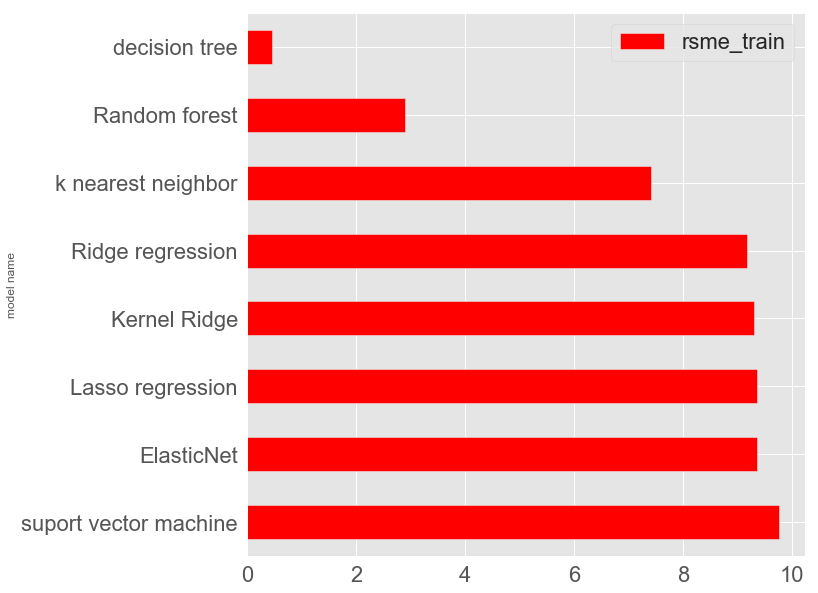

In [15]:

figsize(10,10)

plt.style.use("ggplot")
model_comparison = pd.DataFrame({"model name":["Ridge regression", "Lasso regression", "ElasticNet", "Kernel Ridge",
                                               "suport vector machine", "Random forest","decision tree",
                                               "k nearest neighbor"],
                                "rsme_train": [rd_err1, las_err1, ela_err1, krd_err1, svr_err1, rf_err1, dt_err1, knb_err1]})
model_comparison = model_comparison.sort_values("rsme_train", ascending=False).plot(x="model name", y="rsme_train", color="red", kind="barh")

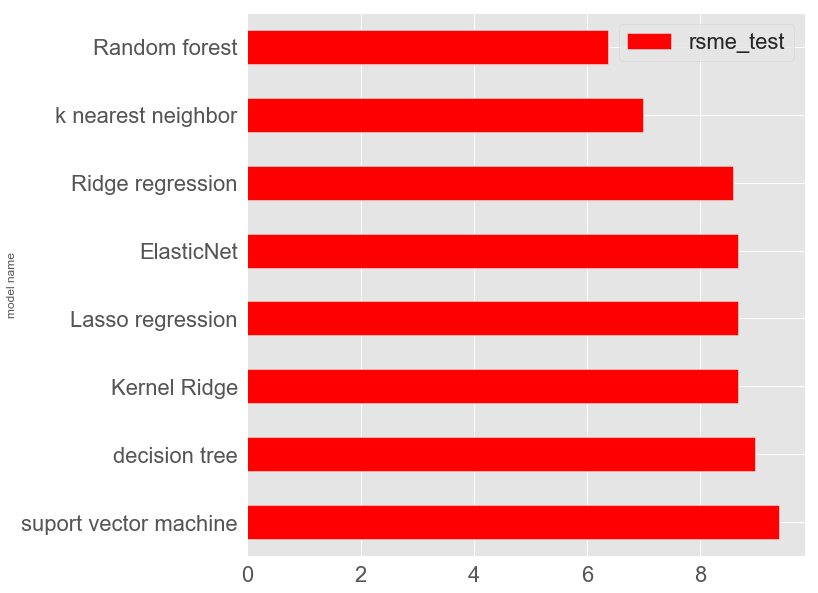

In [16]:

figsize(10,10)

plt.style.use("ggplot")
model_comparison = pd.DataFrame({
    "model name":["Ridge regression", "Lasso regression", "ElasticNet", 
                  "Kernel Ridge", "suport vector machine", 
                  "Random forest","decision tree","k nearest neighbor"],
    "rsme_test": [rd_err2, las_err2, ela_err2, krd_err2, svr_err2, rf_err2, dt_err2, knb_err2]})
model_comparison = model_comparison.sort_values("rsme_test", ascending=False).plot(x="model name", y="rsme_test", color="red", kind="barh")